# Import all the libraries required and cofiguring the GPU

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import math
!pip install -q -U keras-tuner
import keras_tuner as ktPI
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Import a pre-trained model from keras using the weights from ImageNet

In [3]:
img_width, img_height = 224, 224 #Set the image size
#Check the picture layout
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
#Save the imported model in variable called base_model
base_model=tf.keras.applications.ResNet101V2(
    include_top=False,
    input_shape=input_shape,
    weights="imagenet",
)

#Freez the layers in order to not lose the weights
for layer in base_model.layers:
        layer.trainable = False


        

# Use Image data generator for data augmentation

In [4]:
train_data_dir = '/content/Training_data_c' #Instantiate the path for dataset 
batch_size = 128 #Set the batch size

#Set the variables for data augmentation
train_datagen = ImageDataGenerator(
       rescale=1./255,
        zoom_range=0.1,
        validation_split=0.2,
        rotation_range=5,
        horizontal_flip=True)
#Apply data augmentation on training set
training_set = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        subset='training',
        class_mode='categorical')
 
#Apply data augmentation on validation set
test_set= train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset='validation',
        shuffle = False,
        class_mode='categorical')
 

test_set.class_indices #Print the classes

Found 227124 images belonging to 7 classes.
Found 56777 images belonging to 7 classes.


{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# Add the layers and parameters to the model for the fine-tuning process with keras tuner

In [5]:
#Create a function that contains the parametes that are going to be fine-tuned
def model_builder(hp):
    
    num_classes = 7#Set the number of output neurons
 
                        
    base_input=base_model.layers[0].input #Save the layers of the pre-trained model
    base_output=base_model.layers[-1].output #Save the output of the last layer
    
    #Add a convolutional layer with neurons between 32 and 512, filter size of 3*3, and regularization between 0.01 and 0.00001
    final_output=layers.Conv2D(hp.Int('units_base', min_value=32, max_value=512, step=32, default=128), kernel_size=(3,3), padding="same",kernel_regularizer=l2(hp.Float('regularizarer_conv_', 1e-5, 1e-2, sampling='LOG', default=1e-3)),name='conv_2d_base')(base_output)
    final_output=layers.BatchNormalization(name='batch_base')(final_output)#Add batch normalization
    final_output=tf.keras.layers.ReLU()(final_output)#Add activation function
    
    #Add one or two convolutional layers
    for i in range(hp.Int('num_layers_conv2d', 1, 2)):
             #Add a convolutional layer with neurons between 32 and 512, filter size of 3*3, and regularization between 0.01 and 0.00001
             final_output=layers.Conv2D(hp.Int('units_conv2d_'+str(i), min_value=32, max_value=512, step=32, default=128), kernel_size=(3,3), padding="same",kernel_regularizer=l2(hp.Float('regularizarer_conv_'+str(i), 1e-5, 1e-2, sampling='LOG', default=1e-3)),name='conv_2d_'+str(i))(final_output)
             final_output=layers.BatchNormalization(name='batch_1_'+str(i))(final_output)#Add batch normalization
             final_output=tf.keras.layers.ReLU()(final_output)#Add activation function

    final_output=layers.GlobalMaxPooling2D(data_format='channels_last')(final_output)#Add GlobalMaxPoolig layer
    
    final_output=layers.Dropout(rate=hp.Float('rate', 0, .2, step=.1, default=.2))(final_output)#Add a Dropout layer with a rate between 0 and 0.2
    final_output=layers.Flatten()(final_output)# Add Flatten layer

    #Add one or two fully connected layers
    for i in range(hp.Int('num_layers_dense', 1, 2)): 
            #Add a fully connected layer with neurons between 32 and 512, filter size of 3*3, and regularization between 0.01 and 0.00001
            final_output=layers.Dense(hp.Int('units_dense_'+str(i), min_value=32, max_value=512, step=32, default=128),kernel_regularizer=l2(hp.Float('regularizarer_dense_'+str(i), 1e-5, 1e-2, sampling='LOG', default=1e-3)),name='dense_'+str(i))(final_output)
            final_output=layers.BatchNormalization(name='batch_2_'+str(i))(final_output)#Add batch normalization
            final_output=tf.keras.layers.ReLU()(final_output)#Add activation function

    final_output=layers.Dense(num_classes,activation='softmax')(final_output)#Add output layer with neurons for each class


new_model=tf.keras.Model(inputs=base_input,outputs=final_output)#Add the new layers to the model
new_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])#Compile the model using adam optimizer
new_model.summary()# Print the model

# Initialize the tuner to find the best model

In [6]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=15,
                     factor=10,
                     project_name='emotion_kt')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

# Start the search and get the best model:

In [7]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #Stops the current search if there is no improvment
tuner.search(training_set ,validation_data=test_set, epochs=15,callbacks=[stop_early])#Runs the serach for parameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]#Retrive the best parameter

Trial 20 Complete [20h 38m 53s]
val_loss: 0.911815345287323

Best val_loss So Far: 0.8617731332778931
Total elapsed time: 08h 10m 25s
INFO:tensorflow:Oracle triggered exit


# Train the model for 50 epochs and save the best weights using ModelCheckpoint

In [8]:
model = tuner.hypermodel.build(best_hps)
#Create a folder with the best models
directory='Checkpoint_Resnet101V2-V9'
name='Model'
saved = os.path.join(directory, name + "-{epoch:02d}.h5")
#Set up the ModelChepoint
callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=saved, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
)
#Train the model
history=model.fit(training_set,
        epochs=50,
        callbacks=callback,
        steps_per_epoch=227124 // batch_size,
        validation_data=test_set,
        validation_steps= 56777 // batch_size)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Epoch 1/50
1774/1774 [==============================] - 2336s 1s/step - loss: 1.0659 - accuracy: 0.6493 - val_loss: 0.9616 - val_accuracy: 0.6848
Epoch 2/50
1774/1774 [==============================] - 2341s 1s/step - loss: 0.9417 - accuracy: 0.6950 - val_loss: 0.9373 - val_accuracy: 0.7035
Epoch 3/50
1774/1774 [==============================] - 2343s 1s/step - loss: 0.9251 - accuracy: 0.7055 - val_loss: 0.9313 - val_accuracy: 0.7052
Epoch 4/50
1774/1774 [==============================] - 2340s 1s/step - loss: 0.9061 - accuracy: 0.7117 - val_loss: 0.9000 - val_accuracy: 0.7120
Epoch 5/50
1774/1774 [==============================] - 41614s 23s/step - loss: 0.8803 - accuracy: 0.7176 - val_loss: 0.9123 - val_accuracy: 0.7077
Epoch 6/50
1774/1774 [==============================] - 3015s 2s/step - loss: 0.8667 - accuracy: 0.7214 - val_loss: 0.9075 - val_accuracy: 0.7053
Epoch 7/50
1774/1774 [==============================] - 2410s 1s/step - loss: 0.8560 - accuracy: 0.7220 - val_loss: 0.8931

# Plot the accuracy and cross-entropy diagrams

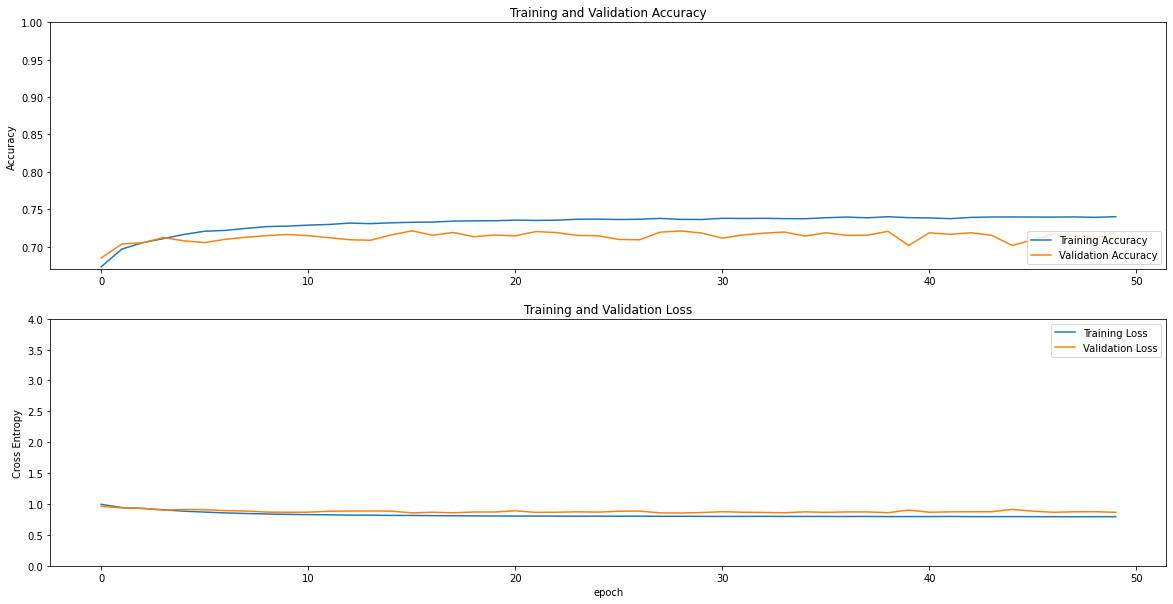

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()